In [1]:
import ddsp
import numpy as np
from ddsp.training import models, eval_util, ddsp_run
from absl import flags
import sys
import os
import gin
import tensorflow as tf
import soundfile as sf
sys.path.append("/home/han/wave2shape/src/")
import ftm_ver2 as ftm
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)



1. load ddsp model 
2. compute predictions
3. 

In [2]:
#load model
exp = "gt_pitch_MSS_cos"
model_dir = os.path.join("/home/han/ddsp/output",exp)
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# Parse gin config,
with gin.unlock_config():
    gin.parse_config_file(gin_file, skip_unknown=True)
# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in os.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[-1].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)
print(ckpt)
# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)


/home/han/ddsp/output/gt_pitch_MSS_cos/ckpt-17000
min and max scaled params [0.0700188044714488 1.0000494356876951e-05 1.000374031049292e-05
 1.2362882382361523e-05] [0.7999966616122908 0.1999951902839537 0.2999173723474814
 0.9999649724709304]


2022-08-29 08:29:30.032462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 08:29:30.531141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 08:29:30.532294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 08:29:30.605460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 08:29:30.606641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
np.arange(4,11)/10

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [4]:
#predict a sound
data_path = "/home/han/data/drum_data/"
df = pd.read_csv("/home/han/data/drum_data/annotations/test_param_v2.csv")
y = df.values[:,1:-1]
sample_ids = df.values[:,0]
i = 0
wav_path = os.path.join(data_path, "test", str(sample_ids[i])+"_sound.wav")
wav, sr = sf.read(wav_path)

scales = np.arange(4,11)/10
wavs = np.stack([wav]*len(scales),axis=0)
wavs = wavs*scales[:,None]
ys = np.stack([y[i,:]]*len(scales),axis=0)
print(wavs.shape,ys.shape)
pred_sound = model([tf.convert_to_tensor(wavs),
                            tf.convert_to_tensor(ys, dtype="float32")], training=False, 
                                return_losses=True)

(7, 65536) (7, 5)


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
2022-08-29 08:30:04.644043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-08-29 08:30:10.449275: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-29 08:30:10.450419: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-29 08:30:10.450704: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-29 08:30:10.472868: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-29 08:30:10.473394: W tensorflow/stream_executor/gpu/redzone_allo

original prediction  tf.Tensor([0.8836154 6.345649  3.1779761 2.5734043], shape=(4,), dtype=float32) gt tf.Tensor([4.2631835e-01 1.5630272e-04 2.4473036e-03 3.9629245e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(5975.38, shape=(), dtype=float32) tf.Tensor([0.7150384 1.2690458 0.9531084 2.5732949], shape=(4,), dtype=float32)


In [5]:
y_est = pred_sound[0]['out']['controls']['all_est']

In [6]:
y_est.numpy()[:,1]- y[i,1]

array([0.62834704, 0.69304454, 0.76524305, 0.8447137 , 0.9229789 ,
       0.9918009 , 1.0529648 ], dtype=float32)

Text(0.5, 1.0, 'MSS wopitch model cosine dist')

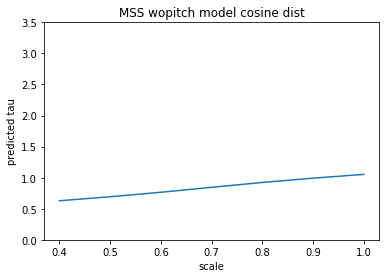

In [16]:
j = 1
plt.plot(scales,y_est.numpy()[:,j]-y[i,j])
plt.xlabel("scale")
plt.ylabel("predicted tau")
plt.ylim([0,3.5])
plt.title("MSS wopitch model cosine dist")

In [4]:
exps = ["gt_pitch_MSS","MSS"]

n = 100

data_path = "/home/han/data/drum_data/"
df = pd.read_csv("/home/han/data/drum_data/annotations/test_param_v2.csv")
y = df.values[:,1:-1]
sample_ids = df.values[:,0]


errors = []
for exp in exps:
    #load model
    model_dir = os.path.join("/home/han/ddsp/output",exp)
    gin_file = os.path.join(model_dir, 'operative_config-0.gin')

    # Parse gin config,
    with gin.unlock_config():
        gin.parse_config_file(gin_file, skip_unknown=True)
    # Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
    ckpt_files = [f for f in os.listdir(model_dir) if 'ckpt' in f]
    ckpt_name = ckpt_files[-1].split('.')[0]
    ckpt = os.path.join(model_dir, ckpt_name)
    print(ckpt)

    # Set up the model just to predict audio given new conditioning
    model = ddsp.training.models.Autoencoder()
    model.restore(ckpt)
    
    #predict
    y_ests = []
    for i, s_i in enumerate(sample_ids):
        if i > (n-1):
            break
        wav_path = os.path.join(data_path, "test", str(s_i)+"_sound.wav")
        audio,sr = sf.read(wav_path)
        #audio_concat.append(audio)
        #ys.append(y[i,:])
        predicted_audio = model([tf.convert_to_tensor(audio[None,:]),
                            tf.convert_to_tensor(y[i,:][None,:], dtype="float32")], training=False, 
                                return_losses=True)
        y_est = predicted_audio[0]['out']['controls']['all_est'][0,:]
        y_ests.append(y_est)

    y_ests = np.stack(y_ests)
    if y_ests.shape[1] == 4:
        error = y_ests - y[:n, 1::]
    else:
        error = y_ests - y[:n, :]
    
    errors.append(error)
    

/home/han/ddsp/output/gt_pitch_MSS/ckpt-8100
min and max scaled params [0.0700188044714488 1.0000494356876951e-05 1.000374031049292e-05
 1.2362882382361523e-05] [0.7999966616122908 0.1999951902839537 0.2999173723474814
 0.9999649724709304]


/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
2022-08-27 12:09:18.046042: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 12:09:18.046834: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 12:09:18.046914: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-27 12:09:18.060513: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 12:09:18.060734: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PAT

original prediction  tf.Tensor([4.8455596 2.763056  4.3258266 3.5242798], shape=(4,), dtype=float32) gt tf.Tensor([4.2631832e-01 1.5630272e-04 2.4473036e-03 3.9629245e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(5975.38, shape=(), dtype=float32) tf.Tensor([3.6071699 0.5525803 1.2973572 3.5241253], shape=(4,), dtype=float32)
original prediction  tf.Tensor([0.         1.5156615  1.2911024  0.90362203], shape=(4,), dtype=float32) gt tf.Tensor([5.4208535e-01 4.4408571e-05 1.6519839e-02 8.4725159e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(282.80722, shape=(), dtype=float32) tf.Tensor([0.07001881 0.30311987 0.38722113 0.9035916 ], shape=(4,), dtype=float32)
original prediction  tf.Tensor([3.7563944 3.7745135 4.1998606 3.7415488], shape=(4,), dtype=float32) gt tf.Tensor([0.54521143 0.00412435 0.01350608 0.9112373 ], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(1988.0175, shape=(), dtype=float32) tf.Tensor([2.8121035 0.7548568

original prediction  tf.Tensor([1.849983   0.59218925 0.21793522 0.86758006], shape=(4,), dtype=float32) gt tf.Tensor([5.6416398e-01 1.3184495e-03 7.3374271e-05 9.1798204e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(5400.1455, shape=(), dtype=float32) tf.Tensor([1.4204654  0.11843908 0.06537038 0.86755127], shape=(4,), dtype=float32)
original prediction  tf.Tensor([3.4733825 2.4560764 3.976685  4.1256986], shape=(4,), dtype=float32) gt tf.Tensor([3.0497694e-01 1.2431385e-03 6.7157933e-05 1.6456904e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(4021.982, shape=(), dtype=float32) tf.Tensor([2.605511  0.4911889 1.1926471 4.1255155], shape=(4,), dtype=float32)
original prediction  tf.Tensor([2.062665  1.7529931 3.0000293 3.1223774], shape=(4,), dtype=float32) gt tf.Tensor([2.53330201e-01 4.82290561e-05 4.69166925e-03 1.23648874e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(1940.6644, shape=(), dtype=float32) tf.Tensor([1.

original prediction  tf.Tensor([2.507897   1.3813313  0.97457784 1.0309942 ], shape=(4,), dtype=float32) gt tf.Tensor([0.70398206 0.00095953 0.00119528 0.11635707], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(3540.3613, shape=(), dtype=float32) tf.Tensor([1.900728   0.27625582 0.29229307 1.0309577 ], shape=(4,), dtype=float32)
original prediction  tf.Tensor([3.9993472 2.3787282 3.6066256 3.6655414], shape=(4,), dtype=float32) gt tf.Tensor([3.2468778e-01 5.1418971e-04 1.5671729e-04 8.4075665e-01], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(4680.1245, shape=(), dtype=float32) tf.Tensor([2.9894536 0.4757204 1.0816636 3.66538  ], shape=(4,), dtype=float32)
original prediction  tf.Tensor([1.6679819 2.242202  2.9385874 2.2288775], shape=(4,), dtype=float32) gt tf.Tensor([0.68914086 0.01237309 0.15600364 0.84610933], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(1353.651, shape=(), dtype=float32) tf.Tensor([1.2876086  0.44841722 0.881314

KeyboardInterrupt: 

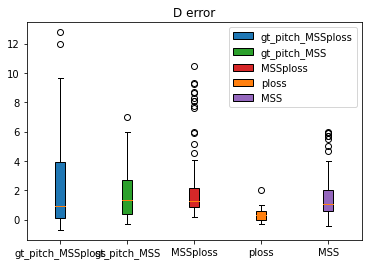

In [9]:
#plot tau prediction
i = 3
gap = 0.1
bp0 = plt.boxplot(errors[0][:,i], labels=[exps[0]], patch_artist=True, positions=[1]) #order 1 is (10 by 3)
bp1 = plt.boxplot(errors[1][:,i], labels=[exps[1]], patch_artist=True, positions=[2])
bp2 = plt.boxplot(errors[2][:,i+1], labels=[exps[2]], patch_artist=True, positions=[3])
bp3 = plt.boxplot(errors[3][:,i+1], labels=[exps[3]], patch_artist=True, positions=[4])
bp4 = plt.boxplot(errors[4][:,i+1], labels=[exps[4]], patch_artist=True, positions=[5])

for box in bp0['boxes']:
    box.set(facecolor = 'C0' )

for box in bp1['boxes']:
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    box.set(facecolor = 'C3' )

for box in bp3['boxes']:
    box.set(facecolor = 'C1' )

for box in bp4['boxes']:
    box.set(facecolor = 'C4' )    
    
plt.title("D error")

plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0], 
            bp3["boxes"][0],
            bp4["boxes"][0]],
           exps, loc='upper right')

In [37]:
error = y_ests - y[:n, 1::]

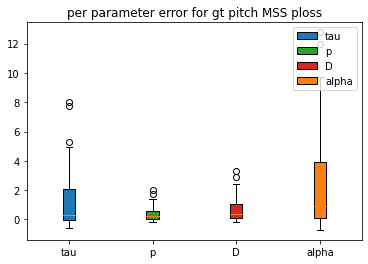

In [40]:
#plot 
gap = 0.1
bp0 = plt.boxplot(error[:,0], labels=["tau"], patch_artist=True, positions=[1]) #order 1 is (10 by 3)
bp1 = plt.boxplot(error[:,1], labels=["p"], patch_artist=True, positions=[2])
bp2 = plt.boxplot(error[:,2], labels=["D"], patch_artist=True, positions=[3])
bp3 = plt.boxplot(error[:,3], labels=["alpha"], patch_artist=True, positions=[4])


for box in bp0['boxes']:
    box.set(facecolor = 'C0' )

for box in bp1['boxes']:
    box.set(facecolor = 'C2' )

for box in bp2['boxes']:
    box.set(facecolor = 'C3' )

for box in bp3['boxes']:
    box.set(facecolor = 'C1' )
    
    
plt.title("per parameter error for gt pitch MSS ploss")

plt.legend([bp0["boxes"][0], bp1["boxes"][0],bp2["boxes"][0], bp3["boxes"][0]], 
           ['tau', 'p', 'D', 'alpha'], loc='upper right')

In [29]:
np.mean(y_ests - y[:n, 1::], axis=0)

array([0.36581157421966337, 0.21692012697805377, 0.4059662568978837,
       0.1873189430753661], dtype=object)

In [6]:
predicted_audio = model([tf.convert_to_tensor(audio_concat),
                        tf.convert_to_tensor(ys, dtype="float32")], training=False, return_losses=True)

/home/han/miniconda3/envs/py38/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
2022-08-22 09:45:04.731389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-08-22 09:45:05.228258: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 09:45:05.228644: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 09:45:05.228671: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-22 09:45:05.229214: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 09:45:05.229290: W tensorflow/stream_executor/gpu/redzone_allo

original prediction  tf.Tensor([0.96045244 1.0902866  1.3832778  0.93478024], shape=(4,), dtype=float32) gt tf.Tensor([0.40531614 0.00113108 0.00889895 0.7474294 ], shape=(4,), dtype=float32)
after scaling prediction  tf.Tensor(2155.3376, shape=(), dtype=float32) tf.Tensor([0.77112776 0.2180512  0.41486517 0.9347483 ], shape=(4,), dtype=float32)


In [7]:
predicted_audio[0].keys(),predicted_audio[1].keys()

(dict_keys(['inputs', 'audio', 'feat', 'param', 'y_predicted', 'ftm', 'out', 'audio_synth']),
 dict_keys(['total_loss']))

In [9]:
predicted_audio[0]['out']['controls']

{'w_est': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([5975.38   ,  282.80722, 1988.0175 ,  375.14594], dtype=float32)>,
 'tau_est': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.2372823 , 0.23471904, 0.54249096, 0.07001881], dtype=float32)>,
 'p_est': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5087157 , 0.25875923, 0.08608301, 0.01864688], dtype=float32)>,
 'D_est': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.59509516, 0.7683163 , 0.13739432, 0.15865496], dtype=float32)>,
 'alpha_est': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.6500306 , 1.7485636 , 0.21905863, 0.12134039], dtype=float32)>,
 'all_est': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[2.2372823 , 0.5087157 , 0.59509516, 1.6500306 ],
        [0.23471904, 0.25875923, 0.7683163 , 1.7485636 ],
        [0.54249096, 0.08608301, 0.13739432, 0.21905863],
        [0.07001881, 0.01864688, 0.15865496, 0.12134039]], dtype=float32)>}

In [13]:
#gt MSSploss
for i in range(4):
    display(ipd.Audio(predicted_audio[0]['out']['signal'][0][i,:], rate=sr))
    display(ipd.Audio(audio_concat[i,:], rate=sr))


In [10]:
#MSSploss
for i in range(4):
    display(ipd.Audio(predicted_audio[0]['out']['signal'][0][i,:], rate=sr))
    display(ipd.Audio(audio_concat[i,:], rate=sr))


In [6]:
#ploss
for i in range(4):
    display(ipd.Audio(predicted_audio[0]['out']['signal'][0][i,:], rate=sr))
    display(ipd.Audio(audio_concat[i,:], rate=sr))


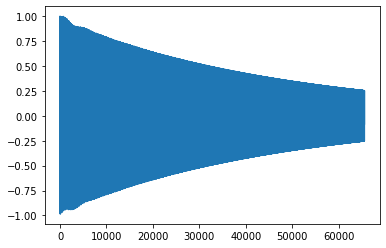

In [21]:
import matplotlib.pyplot as plt
plt.plot(predicted_audio[0]['out']['signal'][0].numpy()[0,:])

In [ ]:
#after having reasonable output
test_fils = os.listdir("/home/han/data/drum_data/test")
for path in test_files:
    wav,sr = sf.read(path)
    pred = model(tf.convert_to_tensor(wav[None,:]), training=False, return_losses=True)
    pred_audio = pred[0]['out'].numpy()
    #compute metrics
    #jtfs
    #dim reduction
    #mulog
    #standardize
    
    #query in the graph
    #etc
    